<a href="https://colab.research.google.com/github/aparnasree2020/sampledata_casws/blob/main/Run_Models_compare_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [61]:
# Comment after installation so that the whole notebook can be run in one go
#install.packages('gbm')
#install.packages('xgboost')
#install.packages('pROC')
#install.packages('reshape2')



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gdtools’




In [ ]:
#Todo 
# Add time taken by each model
# Predict on train data so that overfitting can be estimated / understood
# 

# Load Libraries

In [62]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(gbm)
library(reshape2 )

#library(measures)

ERROR: ignored

# Load CSV datafile - Split data into train and test at 80/20 split

*   List item
*   List item

In [16]:
train_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_train_clean.csv"
test_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_test_clean.csv"
train_data <- read.csv(file =train_file, header = TRUE )
test_data <- read.csv(file =test_file, header = TRUE )
x_train <- train_data[, !names(train_data) %in% "claim_count_pd"]
y_train <- train_data$claim_count_pd
x_test <- test_data[, !names(test_data) %in% "claim_count_pd"]
y_test <- test_data$claim_count_pd

# Fit GLM model and Predict output for test data

In [18]:
# Fit a GLM
fit <- step(glm(y_train ~ ., data = x_train, family = "gaussian"), direction = "both", trace = FALSE)
pred_y_test <- predict(fit, newdata = x_test, type = "response")
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
dataout_GLM <- data.frame(pred_y_test_bin, y_test)
#write.csv(dataout_GLM, "GLM_stepwise_allfeatures.csv", row.names=FALSE)


#Fit GBM model and Predict output for test with standard hyperparameters

In [49]:
fit <- gbm(y_train ~ ., data = x_train, distribution = "gaussian", n.trees = 100, interaction.depth = 5)
pred_y_test = predict.gbm(fit, x_test)
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
dataout_GBM <- data.frame(pred_y_test_bin, y_test)


Using 100 trees...




#XGboost with standard hyperparameters ( no tuning) 

In [ ]:
fit <- xgboost(data = as.matrix(x_train), label = y_train, nrounds = 100, objective = "binary:logistic", eta = 0.3, max_depth = 6,silent = 1)
pred_y_test <- predict(fit, as.matrix(x_test)) # Predict the classes for the test data
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test)

#Calcualte the metric for each model

In [63]:
library(pROC)

# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    compute_model_metrics(dataout_GBM$pred_y_test_bin, dataout_XGboost_simple$y_test, "GBM"),
                    compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Pretty print table of metrics

In [64]:
knitr::kable(metrics_df,digits = 2)



|var_name | accuracy| precision| sensitivity| f1_score|   roc_auc| gini|  TP| FP|    TN|   FN| Samples|
|:--------|--------:|---------:|-----------:|--------:|---------:|----:|---:|--:|-----:|----:|-------:|
|XGBoost  |     0.91|      0.98|        0.07|     0.13| 0.5360971| 0.07| 580|  9| 71971| 7440|   80000|
|GBM      |     0.90|      1.00|        0.00|     0.00| 0.5001247| 0.00|   2|  0| 71980| 8018|   80000|
|GLM      |     0.90|      0.50|        0.00|     0.00| 0.5001108| 0.00|   2|  2| 71978| 8018|   80000|

#Plot the various metrics as plots

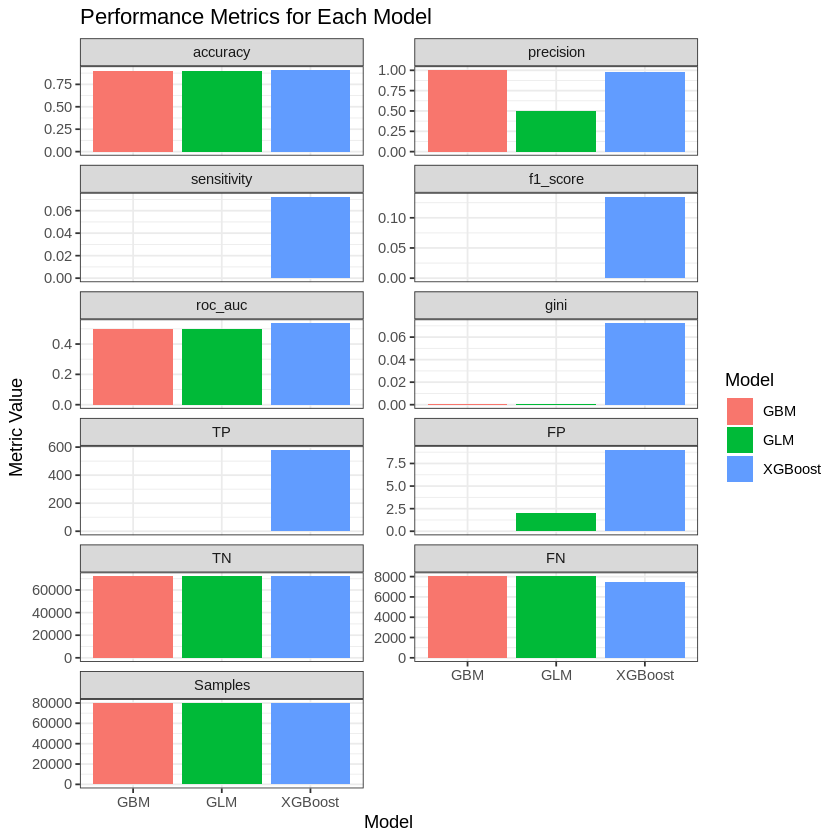

In [65]:
options(warn=-1)
# Melt the data frame to a long format for plotting
metrics_df_melt <- melt(metrics_df, id.vars = "var_name", variable.name = "metric")

# Plot each performance metric for each model using ggplot2 and facet_wrap()
ggplot(metrics_df_melt, aes(x = var_name, y = value, fill = var_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Metric Value", fill = "Model") +
  ggtitle("Performance Metrics for Each Model") +
  facet_wrap(~metric, scales = "free_y", nrow = 10) +
  theme_bw() +
  theme(plot.background = element_rect(fill = "white", size = 4),
        panel.background = element_rect(fill = "white", size = 4))

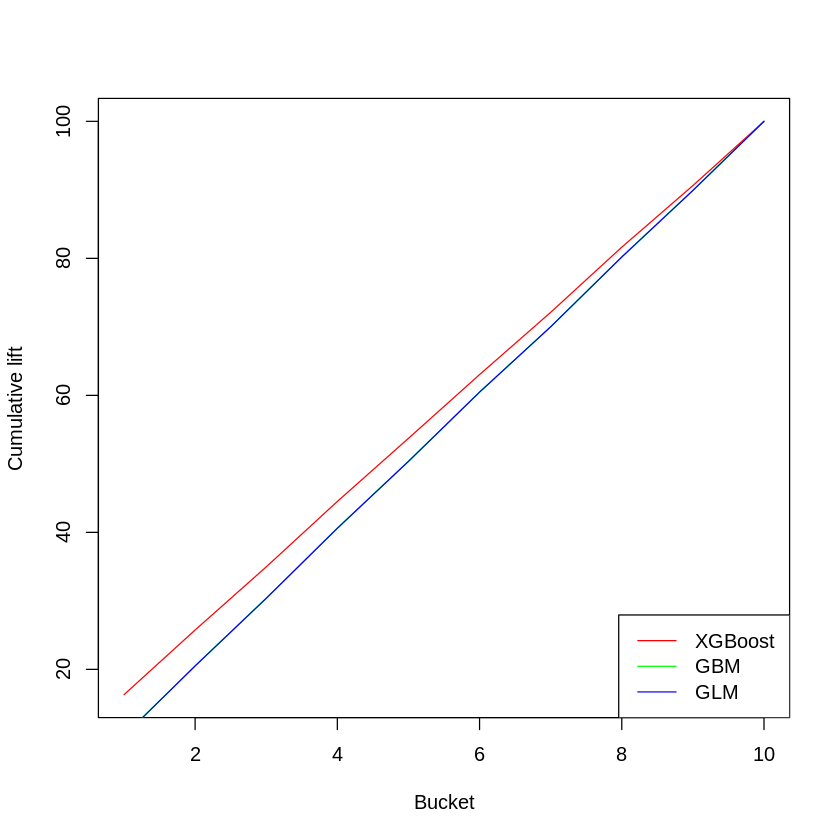

In [66]:
library(dplyr)
options(warn=-1)
# Define the lift function
lift <- function(depvar, predcol, groups=10) {
  if(!require(dplyr)) {
    install.packages("dplyr")
    library(dplyr)
  }
  if(is.factor(depvar)) depvar <- as.integer(as.character(depvar))
  if(is.factor(predcol)) predcol <- as.integer(as.character(predcol))
  helper = data.frame(cbind(depvar, predcol))
  helper[,"bucket"] = ntile(-helper[,"predcol"], groups)
  gaintable = helper %>% group_by(bucket)  %>%
    summarise_at(vars(depvar), funs(total = n(),
                                    totalresp=sum(., na.rm = TRUE))) %>%
    mutate(Cumresp = cumsum(totalresp),
           Gain=Cumresp/sum(totalresp)*100,
           Cumlift=Gain/(bucket*(100/groups)))
  return(gaintable)
}

# Example usage
dt1 <- lift(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin, groups = 10)
dt2 <- lift(dataout_GBM$y_test, dataout_GBM$pred_y_test_bin, groups = 10)
dt3 <- lift(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin, groups = 10)

# Plot the lift charts with different colors
graphics::plot(dt1$bucket, dt1$Gain, type="l", ylab="Cumulative lift", xlab="Bucket", col="red",linetype = "dashed")
lines(dt2$bucket, dt2$Gain, col="green")
lines(dt3$bucket, dt3$Gain, col="blue",linetype = "dashed")
legend("bottomright", legend=c("XGBoost", "GBM", "GLM"), col=c("red", "green", "blue"), lty=1)

# End

Unused code below

In [ ]:
#library(Hmisc)
#hist.data.frame(gbm_data$claim_count_pd)

In [ ]:
#library(flextable)
# Convert the data frame to a flextable object
ft_metrics <- flextable(metrics_df)
ft_metrics <- set_formatter(ft_metrics, type = "numeric", digits = 2) # Set the number of decimal places for numeric columns

ft_metrics <- set_header_labels(ft_metrics, var_name = "Model", Samples = "Total Samples")
ft_metrics <- autofit(ft_metrics)
ft_metrics <- add_header_row(ft_metrics, values = "Performance Metrics", merge = 11)
print(ft_metrics)